# Crime Patterns in Chicago
*Examining the Relationship Between Daytime and Nighttime Crime Rates*

## Setup

### Imports

In [135]:
!pip install astral

In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# from google.colab import drive
from pyproj import Transformer
from sklearn.preprocessing import LabelEncoder
from astral import LocationInfo
from astral.sun import sun
from scipy.stats import pearsonr
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, HalvingRandomSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import warnings

warnings.filterwarnings("ignore")

### Load Data

In [65]:
# Fix columns names
df = pd.read_csv("crimes_data_chicago.csv")
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)\
                      .str.strip().str.lower()\
                      .str.replace(' ', '_').str.replace('#', '')
df.columns

Index(['case', 'date_of_occurrence', 'block', 'iucr', 'primary_description',
       'secondary_description', 'location_description', 'arrest', 'domestic',
       'beat', 'ward', 'fbi_cd', 'x_coordinate', 'y_coordinate', 'latitude',
       'longitude', 'location'],
      dtype='object')

In [66]:
df.head()

,case,date_of_occurrence,block,iucr,primary_description,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,x_coordinate,y_coordinate,latitude,longitude,location
0,JH432025,09/17/2024 05:07:00 AM,042XX W MADISON ST,0610,BURGLARY,FORCIBLE ENTRY,COMMERCIAL / BUSINESS OFFICE,N,N,1115,28.0,05,1148029.0,1899673.0,41.880651,-87.731914,"(41.880650875, -87.73191358)"
1,JH432024,09/17/2024 05:10:00 AM,032XX N BROADWAY,0860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1925,44.0,06,1171684.0,1921595.0,41.940318,-87.644408,"(41.940318272, -87.644408194)"
2,JH432018,09/17/2024 05:13:00 AM,060XX S PRAIRIE AVE,0420,BATTERY,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,APARTMENT,Y,N,311,20.0,04B,1179074.0,1865064.0,41.785028,-87.618977,"(41.785027633, -87.6189766)"
3,JH432014,09/17/2024 05:13:00 AM,006XX W HUBBARD ST,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,N,N,1214,27.0,04B,1172203.0,1903317.0,41.890151,-87.643041,"(41.890151078, -87.643041403)"
4,JH432319,09/17/2024 05:20:00 AM,048XX W LAKE ST,0880,THEFT,PURSE-SNATCHING,CTA TRAIN,N,N,1532,28.0,06,1144147.0,1901839.0,41.886668,-87.746114,"(41.886668404, -87.746113681)"


## Data Cleaning

**NOTE:** PROVIDE REASONING FOR THIS

In [67]:
# Drop additional columns

columns_to_drop = ['case', 'x_coordinate', 'y_coordinate', 'location', 'iucr']
df = df.drop(columns_to_drop, axis=1)

Quick analysis of what percentage of rows contain NA location

In [68]:
prev_num_rows = len(df.index)

# There are 93 rows where NaN values are in latitude and longitude
df = df.dropna(subset=['longitude', 'latitude'])

# We only have 1 row that has NaN value that is NOT latitude or longitude
# @ index 230265 for Ahmed (Hamood)
#   Drop unnecessary columns for modeling/correlation matrix right before preprocessing step
#   Save this as a separate dataframe!!!
df = df.dropna(subset=['ward'])

curr_num_rows = len(df.index)

print(curr_num_rows/prev_num_rows*100)

99.96087604365235


Grouping of less frequent categories under OTHER

In [69]:
threshold = 0.01

# Display values for location_description, primary_description, secondary_description, fbi_cd
categorical_cols_to_aggr = [ "location_description", "primary_description",  "secondary_description", "fbi_cd"]
for col in categorical_cols_to_aggr:
    uniques = df[col].value_counts()
    # print(f"Unique values in {col}: {len(uniques)}")

    counts = df[col].value_counts(normalize=True)
    to_keep = counts[counts > threshold].index

    df.loc[:, col] = df[col].where(df[col].isin(to_keep), "OTHER")

    display(df[[col]].value_counts())


location_description                  
STREET                                    62594
APARTMENT                                 46881
OTHER                                     32377
RESIDENCE                                 28987
SIDEWALK                                  12508
SMALL RETAIL STORE                         9383
PARKING LOT / GARAGE (NON RESIDENTIAL)     8334
DEPARTMENT STORE                           5754
RESTAURANT                                 5616
ALLEY                                      5500
OTHER (SPECIFY)                            4090
VEHICLE NON-COMMERCIAL                     3766
COMMERCIAL / BUSINESS OFFICE               3451
RESIDENCE - PORCH / HALLWAY                2927
GAS STATION                                2897
GROCERY FOOD STORE                         2626
RESIDENCE - YARD (FRONT / BACK)            2477
Name: count, dtype: int64

primary_description
THEFT                  56528
BATTERY                43289
CRIMINAL DAMAGE        26377
ASSAULT                21941
MOTOR VEHICLE THEFT    17610
OTHER OFFENSE          16616
DECEPTIVE PRACTICE     14487
BURGLARY                9189
OTHER                   8761
NARCOTICS               7337
ROBBERY                 6963
WEAPONS VIOLATION       5902
CRIMINAL TRESPASS       5168
Name: count, dtype: int64

secondary_description                  
OTHER                                      56256
SIMPLE                                     30232
DOMESTIC BATTERY SIMPLE                    19122
$500 AND UNDER                             16194
TO VEHICLE                                 14600
OVER $500                                  14352
RETAIL THEFT                               13866
AUTOMOBILE                                 13455
TO PROPERTY                                11195
THEFT FROM MOTOR VEHICLE                    5926
AGGRAVATED - HANDGUN                        5156
UNLAWFUL POSSESSION - HANDGUN               4428
FROM BUILDING                               4411
FORCIBLE ENTRY                              3561
TO LAND                                     3210
TELEPHONE THREAT                            3150
AGGRAVATED - OTHER DANGEROUS WEAPON         2891
FRAUD OR CONFIDENCE GAME                    2782
FINANCIAL IDENTITY THEFT OVER $ 300         2730
BURGLARY FROM MOTOR VEHICLE  

fbi_cd
06        59192
08B       36243
14        26377
26        18999
08A       18727
07        17610
11        13349
OTHER      8389
04B        7396
18         7334
03         6963
04A        6896
05         6525
15         6168
Name: count, dtype: int64

Creating day/time binary column

In [70]:
df["date_of_occurrence"] = pd.to_datetime(df["date_of_occurrence"])
city = LocationInfo("Chicago", "USA", "America/Chicago", 41.8781, -87.6298)

def is_daytime(ts):
  # Check if the timestamp is NaT before localizing
  if pd.isna(ts):
    return 0 # Or handle missing timestamps as appropriate for your analysis

  # Localize the timestamp to the city's timezone, handling ambiguous times by setting them to NaT
  ts_localized = ts.tz_localize(city.timezone, ambiguous='NaT')

  # Check if localization resulted in NaT (due to ambiguity or original NaT)
  if pd.isna(ts_localized):
      return 0 # Or handle as appropriate

  # Get sunrise and sunset for the date of the localized timestamp
  s = sun(city.observer, date=ts_localized.date(), tzinfo=city.timezone)

  # Check if sunrise or sunset is NaT
  if pd.isna(s["sunrise"]) or pd.isna(s["sunset"]):
      return 0 # Or handle as appropriate

  return int(s["sunrise"] <= ts_localized <= s["sunset"])

# Apply the function to the date_of_occurrence column
df["is_daytime"] = df["date_of_occurrence"].apply(is_daytime)

In [71]:
df.head(3)

,date_of_occurrence,block,primary_description,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,latitude,longitude,is_daytime
0,2024-09-17 05:07:00,042XX W MADISON ST,BURGLARY,FORCIBLE ENTRY,COMMERCIAL / BUSINESS OFFICE,N,N,1115,28.0,05,41.880651,-87.731914,0
1,2024-09-17 05:10:00,032XX N BROADWAY,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1925,44.0,06,41.940318,-87.644408,0
2,2024-09-17 05:13:00,060XX S PRAIRIE AVE,BATTERY,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,APARTMENT,Y,N,311,20.0,04B,41.785028,-87.618977,0


In [72]:
df.loc[:, 'arrest'] = df['arrest'].map({'Y': True, 'N': False})
df.loc[:, 'domestic'] = df['domestic'].map({'Y': True, 'N': False})

## Exploratory Data Analysis

In [ ]:
# @title Function for displaying correlation
def show_day_night_correlations(df, target_col, loc_col, daytime_col='is_daytime'):
    # 1. Ensure target is numeric (0 or 1) for the entire operation
    # We create a copy so we don't modify your original dataframe
    work_df = df.copy()
    work_df[target_col] = work_df[target_col].astype(int)

    # 2. TABLE: Calculate correlations split by Day/Night
    results = {}
    locations = work_df[loc_col].unique()

    for loc in locations:
        loc_binary = (work_df[loc_col] == loc).astype(int)

        # Day Stats
        mask_day = work_df[daytime_col] == True
        if mask_day.sum() > 0:
            r_day, p_day = pearsonr(loc_binary[mask_day], work_df.loc[mask_day, target_col])
        else:
            r_day, p_day = 0, 1.0

        # Night Stats
        mask_night = work_df[daytime_col] == False
        if mask_night.sum() > 0:
            r_night, p_night = pearsonr(loc_binary[mask_night], work_df.loc[mask_night, target_col])
        else:
            r_night, p_night = 0, 1.0

        results[loc] = {
            "Corr_Day": r_day, "P_Day": p_day,
            "Corr_Night": r_night, "P_Night": p_night,
            "Diff (Day-Night)": r_day - r_night
        }

    results_df = pd.DataFrame(results).T.sort_values("Diff (Day-Night)", ascending=False)

    def style_sig(val):
        return 'color: red' if val >= 0.01 else 'color: green'

    display(results_df.style.map(style_sig, subset=['P_Day', 'P_Night'])
            .format("{:.3f}")
            .background_gradient(subset=['Diff (Day-Night)'], cmap='coolwarm'))

    # 3. VISUALIZATION: Heatmap
    # Now using 'work_df' where target_col is guaranteed to be numeric
    pivot_df = work_df.pivot_table(
        index=loc_col,
        columns=daytime_col,
        values=target_col,
        aggfunc='mean'
    )

    pivot_df.columns = [f'Night ({target_col} rate)', f'Day ({target_col} rate)']

    plt.figure(figsize=(8, len(pivot_df) * 0.4 + 2))
    sns.heatmap(pivot_df, annot=True, cmap="Reds", fmt=".1%", cbar_kws={'label': 'Probability'})
    plt.title(f"Impact of {daytime_col} on {target_col} by Location")
    plt.ylabel("Location")
    plt.show()

,Corr_Day,P_Day,Corr_Night,P_Night,Diff (Day-Night)
SIDEWALK,0.121,0.000,0.083,0.000,0.038
ALLEY,0.079,0.000,0.042,0.000,0.038
SMALL RETAIL STORE,0.046,0.000,0.020,0.000,0.026
GROCERY FOOD STORE,0.040,0.000,0.016,0.000,0.023
DEPARTMENT STORE,0.074,0.000,0.056,0.000,0.018
VEHICLE NON-COMMERCIAL,-0.004,0.147,-0.014,0.000,0.010
RESIDENCE - YARD (FRONT / BACK),-0.003,0.314,-0.006,0.059,0.003
GAS STATION,0.030,0.000,0.027,0.000,0.003
PARKING LOT / GARAGE (NON RESIDENTIAL),-0.026,0.000,-0.029,0.000,0.003
STREET,0.029,0.000,0.032,0.000,-0.003


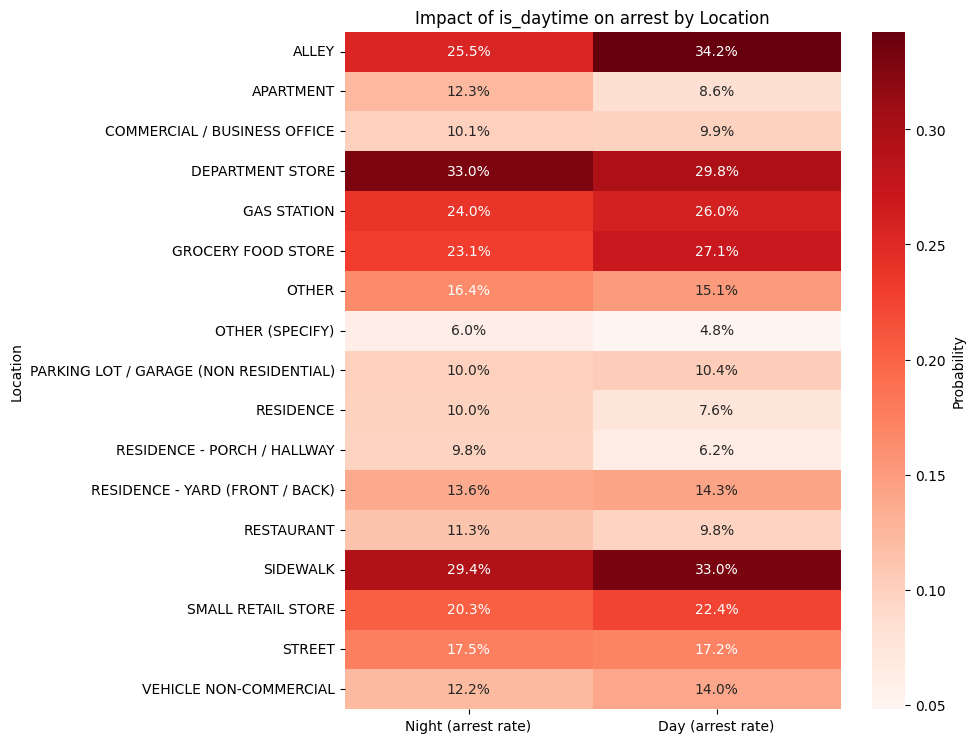

In [ ]:
show_day_night_correlations(df, 'arrest', 'location_description')

## Modeling

### Data Preparation & Engineering Helper Functions

In [73]:
# Run only in the beginning
real = df.copy()

In [74]:
def initial_data_preparation():
    df = real.copy()

    categorical_cols = ['primary_description', 'secondary_description', 'location_description', 'beat', 'ward', 'fbi_cd']

    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    encoded = ohe.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_cols))

    df_encoded = pd.concat([
        df.drop(columns=categorical_cols),
        encoded_df
    ], axis=1)

    df_encoded = df_encoded.dropna(axis=0).reset_index(drop=True)

    y = df_encoded['is_daytime']
    X = df_encoded.drop(columns=['block', 'is_daytime', 'date_of_occurrence'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test
    

In [76]:
def feature_engineering():
    df = real.copy()

    # Time features 
    df['month'] = df['date_of_occurrence'].dt.month
    df['weekday'] = df['date_of_occurrence'].dt.weekday
    df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    dayofyear = df['date_of_occurrence'].dt.dayofyear
    df['sin_dayofyear'] = np.sin(2 * np.pi * dayofyear / 365.25)
    df['cos_dayofyear'] = np.cos(2 * np.pi * dayofyear / 365.25)

    df['approx_daylight_hours'] = 12 + 4 * np.sin(2 * np.pi * (dayofyear - 80) / 365.25)
    df['daylight_fraction'] = df['approx_daylight_hours'] / 24.0

    df['season'] = pd.cut(
        df['month'],
        bins=[0, 3, 6, 9, 12],
        labels=['winter', 'spring', 'summer', 'fall']
    )

    # GEO CLUSTER FEATURE 
    coords = df[['latitude', 'longitude']].copy()
    coords = coords.fillna(coords.median())  # safety

    kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
    df['geo_cluster'] = kmeans.fit_predict(coords)

    # Location related data
    outdoor_locs = [
        'STREET',
        'SIDEWALK',
        'ALLEY',
        'PARKING LOT / GARAGE (NON RESIDENTIAL)',
        'RESIDENCE - YARD (FRONT / BACK)',
        'RESIDENCE - PORCH / HALLWAY',
    ]
    df['is_outdoor'] = df['location_description'].isin(outdoor_locs).astype(int)

    business_locs = [
        'COMMERCIAL / BUSINESS OFFICE',
        'SMALL RETAIL STORE',
        'DEPARTMENT STORE',
        'GAS STATION',
        'RESTAURANT',
        'GROCERY FOOD STORE',
    ]
    df['is_business_area'] = df['location_description'].isin(business_locs).astype(int)

    # Combos
    df['crime_day_combo'] = df['primary_description'] + "_" + df['weekday'].astype(str)
    df['loc_day_combo'] = df['location_description'] + "_" + df['weekday'].astype(str)
    df["crime_arrest_combo"] = df["primary_description"] + "_" + df["arrest"].astype(int).astype(str)
    df["loc_domestic_combo"] = df["location_description"] + "_" + df["domestic"].astype(int).astype(str)
    df["arrest_weekday_combo"] = df["arrest"].astype(int).astype(str) + "_" + df["weekday"].astype(str)
    df["arrest_month_combo"] = df["arrest"].astype(int).astype(str) + "_" + df["month"].astype(str)
    df['crime_location_combo'] = df['primary_description'] + "_" + df['location_description']
    df['domestic_weekday_combo'] = df['domestic'].astype(int).astype(str) + "_" + df['weekday'].astype(str)
    df['domestic_season_combo'] = df['domestic'].astype(int).astype(str) + "_" + df['season'].astype(str)
    
    # time-behavior features
    beat_weekend_rate = df.groupby('beat')['is_weekend'].mean()
    df['beat_weekend_rate'] = df['beat'].map(beat_weekend_rate)

    beat_outdoor_rate = df.groupby('beat')['is_outdoor'].mean()
    df['beat_outdoor_rate'] = df['beat'].map(beat_outdoor_rate)

    beat_business_rate = df.groupby('beat')['is_business_area'].mean()
    df['beat_business_rate'] = df['beat'].map(beat_business_rate)

    crime_weekend_rate = df.groupby('primary_description')['is_weekend'].mean()
    df['crime_weekend_rate'] = df['primary_description'].map(crime_weekend_rate)

    loc_weekend_rate = df.groupby('location_description')['is_weekend'].mean()
    df['loc_weekend_rate'] = df['location_description'].map(loc_weekend_rate)

    # Approx distance from downtown Chicago 
    chi_center_lat, chi_center_lon = 41.8781, -87.6298
    df['dist_from_center'] = np.sqrt(
        (df['latitude'] - chi_center_lat) ** 2 +
        (df['longitude'] - chi_center_lon) ** 2
    )

    # CATEGORICAL ENCODING 
    categorical_cols = [
        'location_description',
        'beat',
        'ward',
        'fbi_cd',
        'crime_day_combo',
        'loc_day_combo',
        'geo_cluster',
        'secondary_description',
        'crime_arrest_combo',
        'loc_domestic_combo',
        'arrest_weekday_combo',
        'arrest_month_combo',
        'season',
        'crime_location_combo',
        'domestic_weekday_combo',
        'domestic_season_combo'
    ]

    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = ohe.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_cols))

    df_encoded = pd.concat([
        df.drop(columns=categorical_cols),
        encoded_df
    ], axis=1)

    df_encoded = df_encoded.dropna(axis=0).reset_index(drop=True)

    y = df_encoded['is_daytime']
    X = df_encoded.drop(columns=['block', 'is_daytime', 'date_of_occurrence', 'primary_description'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

### Modeling Helper Functions

In [77]:
X_train, X_test, y_train, y_test = feature_engineering()

In [78]:
def cross_validate_model(model):
    cr = cross_validate(
        model,
        X_train,
        y_train,
        scoring=['f1', 'roc_auc', 'accuracy'],
        n_jobs=-1,
        cv=5
    )

    print(f"Mean F1 Score: {cr['test_f1'].mean()}")
    print(f"Mean ROC AUC: {cr['test_roc_auc'].mean()}")
    print(f"Mean Accuracy: {cr['test_accuracy'].mean()}")

    return cr

In [79]:
def grid_search(base_estimator, params):
    grid = GridSearchCV(
        estimator=base_estimator,
        param_grid=params,
        scoring={
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X_train, y_train)

    print("Best params this round:", grid.best_params_)

    best_idx = grid.best_index_
    mean_f1 = grid.cv_results_['mean_test_f1'][best_idx]
    mean_roc = grid.cv_results_['mean_test_roc_auc'][best_idx]
    mean_acc = grid.cv_results_['mean_test_accuracy'][best_idx]

    print(f"Best F1 (CV):       {mean_f1:.4f}")
    print(f"Best ROC AUC (CV):  {mean_roc:.4f}")
    print(f"Best Accuracy (CV): {mean_acc:.4f}")

    return grid

In [82]:
def halving_search(base_estimator, param_dist,
                   min_resources=80,
                   max_resources=600,
                   factor=2):

    search = HalvingRandomSearchCV(
        estimator=base_estimator,
        param_distributions=param_dist,
        scoring='f1',
        refit=True,
        resource="max_iter",
        min_resources=min_resources,
        max_resources=max_resources,
        factor=factor,
        cv=3,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X_train, y_train)

    print("Best params this round:", search.best_params_)

    mean_f1 = search.best_score_

    best_est = search.best_estimator_

    mean_roc = cross_val_score(
        best_est, X_train, y_train,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

    mean_acc = cross_val_score(
        best_est, X_train, y_train,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    ).mean()

    print(f"Best F1 (CV):       {mean_f1:.4f}")
    print(f"Best ROC AUC (CV):  {mean_roc:.4f}")
    print(f"Best Accuracy (CV): {mean_acc:.4f}")

    return search

In [152]:
def halving_search_rf(base_estimator, param_dist,
                      min_resources=None,
                      max_resources=None,
                      factor=2):

    base_n_estimators = getattr(base_estimator, "n_estimators", 100)

    if min_resources is None:
        min_resources = max(50, base_n_estimators // 3)
    if max_resources is None:
        max_resources = max(base_n_estimators, base_n_estimators * 2)

    search = HalvingRandomSearchCV(
        estimator=base_estimator,
        param_distributions=param_dist,
        scoring='f1', 
        refit=True,
        resource="n_estimators",
        min_resources=min_resources,
        max_resources=max_resources,
        factor=factor,
        cv=3,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X_train, y_train)

    print("Best params this round:", search.best_params_)

    mean_f1 = search.best_score_

    best_est = search.best_estimator_

    mean_roc = cross_val_score(
        best_est, X_train, y_train,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

    mean_acc = cross_val_score(
        best_est, X_train, y_train,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    ).mean()

    print(f"Best F1 (CV):       {mean_f1:.4f}")
    print(f"Best ROC AUC (CV):  {mean_roc:.4f}")
    print(f"Best Accuracy (CV): {mean_acc:.4f}")

    return search

### Baselines

#### KNN

In [ ]:
X_train, X_test, y_train, y_test = initial_data_preparation()
knn = cross_validate_model(KNeighborsClassifier(n_neighbors=1))

Mean F1 Score: 0.5947395869921666
Mean ROC AUC: 0.5473085573873024
Mean Accuracy: 0.5522492970946578


#### Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = initial_data_preparation()
dt = cross_validate_model(DecisionTreeClassifier())

Mean F1 Score: 0.6005744464445497
Mean ROC AUC: 0.5484842953278912
Mean Accuracy: 0.5545871081953556


#### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = initial_data_preparation()
lr = cross_validate_model(LogisticRegression())


Mean F1 Score: 0.664214540598943
Mean ROC AUC: 0.6350403772073239
Mean Accuracy: 0.6042642924086223


### Ensemble Models

#### Random Forest

In [ ]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Baseline Random Forest
X_train, X_test, y_train, y_test = initial_data_preparation()
rf_cv = cross_validate_model(rf)

Mean F1 Score: 0.6457371260379418
Mean ROC AUC: 0.6177651688383309
Mean Accuracy: 0.5919243986254294


In [ ]:
# Random Forest after feature engineering
X_train, X_test, y_train, y_test = feature_engineering()
rf_cv = cross_validate_model(rf)

Mean F1 Score: 0.6959196158988961
Mean ROC AUC: 0.6965785764833298
Mean Accuracy: 0.6465063001145476


##### Grid Search

In [86]:
param_grid_rf_round_1 = {
    'n_estimators': [100, 200, 300, 400],
}

grid1 = grid_search(rf, param_grid_rf_round_1)
best_n_estimators = grid1.best_params_['n_estimators']


param_grid_rf_round_2 = {
    'n_estimators': [best_n_estimators],
    'max_features': ['sqrt', 'log2', 0.5],
}

grid2 = grid_search(rf, param_grid_rf_round_2)
best_max_features = grid2.best_params_['max_features']


param_grid_rf_round_3 = {
    'n_estimators': [best_n_estimators],
    'max_features': [best_max_features],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
}

grid3 = grid_search(rf, param_grid_rf_round_3)
best_min_split = grid3.best_params_['min_samples_split']
best_min_leaf = grid3.best_params_['min_samples_leaf']


param_grid_rf_round_4 = {
    'n_estimators': [best_n_estimators],
    'max_features': [best_max_features],
    'min_samples_split': [best_min_split],
    'min_samples_leaf': [best_min_leaf],
    'class_weight': [None, 'balanced']
}

grid4 = grid_search(rf, param_grid_rf_round_4)
best_class_weight = grid4.best_params_['class_weight']


NameError: name 'rf' is not defined

In [ ]:
base_rf = rf.__class__(
    n_estimators=best_n_estimators,
    max_features=best_max_features,
    min_samples_split=best_min_split,
    min_samples_leaf=best_min_leaf,
    class_weight=best_class_weight,
    random_state=42,
    n_jobs=-1
)

param_dist_rf_final = {
    "max_features": ['sqrt', 'log2', 0.5],
    "min_samples_split": randint(max(2, best_min_split - 8), best_min_split + 9),
    "min_samples_leaf": randint(max(1, best_min_leaf - 4), best_min_leaf + 5),
}

search_rf = halving_search_rf(
    base_estimator=base_rf,
    param_dist=param_dist_rf_final,
    min_resources=int(0.5 * best_n_estimators),
    max_resources=int(1.5 * best_n_estimators),
    factor=2
)

best_params_rf_final = search_rf.best_params_

##### Final Testing (Random Forest)

In [ ]:
# Final evaluation on the test set
best_model = search_rf.best_estimator_

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Test F1:", f1_score(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


#### Hist Gradient Boosting

In [ ]:
hgb = HistGradientBoostingClassifier(
    random_state=42
    )

In [ ]:
# Baseline Gradient Boosting
X_train, X_test, y_train, y_test = initial_data_preparation()
hg_cv = cross_validate_model(hgb)

Mean F1 Score: 0.6680442447387076
Mean ROC AUC: 0.6520784157557497
Mean Accuracy: 0.6144069561595336


In [ ]:
# Gradient Boosting after feature engineering
X_train, X_test, y_train, y_test = feature_engineering()
hg_cv = cross_validate_model(hgb)

Mean F1 Score: 0.7061973636341511
Mean ROC AUC: 0.7195789826631858
Mean Accuracy: 0.6613141726543789


##### Grid search

In [84]:
hgb = HistGradientBoostingClassifier(
    loss='log_loss',
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

In [87]:
param_grid_hgb_round_1 = {
    'learning_rate': [0.08, 0.1, .12],
}
grid1 = grid_search(hgb, param_grid_hgb_round_1)
best_lr = grid1.best_params_['learning_rate']


param_grid_hgb_round_2 = {
    'learning_rate': [best_lr],
    'max_leaf_nodes': [19, 25, 31, 37, 43],
}
grid2 = grid_search(hgb, param_grid_hgb_round_2)
best_leaf_nodes = grid2.best_params_['max_leaf_nodes']


param_grid_hgb_round_3 = {
    'learning_rate': [best_lr],
    'max_leaf_nodes': [best_leaf_nodes],
    'min_samples_leaf': [10, 15, 20, 25, 30],
}
grid3 = grid_search(hgb, param_grid_hgb_round_3)
best_min_leaf = grid3.best_params_['min_samples_leaf']


param_grid_hgb_round_4 = {
    'learning_rate': [best_lr],
    'max_leaf_nodes': [best_leaf_nodes],
    'min_samples_leaf': [best_min_leaf],
    'l2_regularization': [0.0, 0.25, 0.5, 0.75, 1.0],
}
grid4 = grid_search(hgb, param_grid_hgb_round_4)
best_l2 = grid4.best_params_['l2_regularization']


param_grid_hgb_round_5 = {
    'learning_rate': [best_lr],
    'max_leaf_nodes': [best_leaf_nodes],
    'min_samples_leaf': [best_min_leaf],
    'l2_regularization': [best_l2],
    'class_weight': [None, 'balanced']
}
grid5 = grid_search(hgb, param_grid_hgb_round_5)
best_class_weight = grid5.best_params_['class_weight']

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .................................learning_rate=0.12; total time= 2.1min
[CV] END .................................learning_rate=0.12; total time= 2.3min
[CV] END ..................................learning_rate=0.1; total time= 2.3min
[CV] END ..................................learning_rate=0.1; total time= 2.3min
[CV] END ..................................learning_rate=0.1; total time= 2.3min
[CV] END .................................learning_rate=0.12; total time= 2.3min
[CV] END .................................learning_rate=0.08; total time= 2.4min
[CV] END .................................learning_rate=0.08; total time= 2.4min
[CV] END .................................learning_rate=0.08; total time= 2.4min
Best params this round: {'learning_rate': 0.08}
Best F1 (CV):       0.7056
Best ROC AUC (CV):  0.7180
Best Accuracy (CV): 0.6599
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ..............

In [90]:
# WORK HERE
# best_lr = 0.8
# best_leaf_nodes = 43
# best_min_leaf = 10
# best_l2 = 0.0


# Final Round, halving random search based on the previous findings
base_hgb = hgb.__class__(
    loss=hgb.loss,
    learning_rate=best_lr,
    max_leaf_nodes=best_leaf_nodes,
    min_samples_leaf=best_min_leaf,
    max_iter=350,
    l2_regularization=best_l2,
    class_weight=best_class_weight,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42
)

# Learning rate: very wide, but still capped for stability
lr_low  = max(5e-5, best_lr - 0.40)
lr_high = min(1.5,  best_lr + 0.40)
param_lr = uniform(lr_low, lr_high - lr_low)

# Leaf nodes: widen to ±100 (big structural search, still safe)
leaf_low  = max(5, best_leaf_nodes - 100)
leaf_high = best_leaf_nodes + 101

# Min samples per leaf: widen to ±40
min_leaf_low  = max(1, best_min_leaf - 40)
min_leaf_high = best_min_leaf + 41

# L2 regularization: wide span, full sweep through [0, 4]
l2_low  = max(0.0, best_l2 - 2.0)
l2_high = min(4.0,  best_l2 + 2.0)
param_l2 = uniform(l2_low, l2_high - l2_low)

param_dist_hgb_final = {
    "learning_rate": param_lr,
    "max_leaf_nodes": randint(leaf_low, leaf_high),
    "min_samples_leaf": randint(min_leaf_low, min_leaf_high),
    "l2_regularization": param_l2,
}

search = halving_search(
    base_estimator=base_hgb,
    param_dist=param_dist_hgb_final,
    min_resources=80,
    max_resources=600,
    factor=2
)

best_params_final = search.best_params_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 80
max_resources_: 600
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 7
n_resources: 80
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END l2_regularization=0.749080237694725, learning_rate=0.4563453313614393, max_iter=80, max_leaf_nodes=111, min_samples_leaf=8; total time= 2.7min
[CV] END l2_regularization=0.749080237694725, learning_rate=0.4563453313614393, max_iter=80, max_leaf_nodes=111, min_samples_leaf=8; total time= 2.7min
[CV] END l2_regularization=0.749080237694725, learning_rate=0.4563453313614393, max_iter=80, max_leaf_nodes=111, min_samples_leaf=8; total time= 2.8min
[CV] END l2_regularization=0.11282315805420051, learning_rate=0.34657331074946257, max_iter=80, max_leaf_nodes=42, min_samples_leaf=2; total time= 3.2min
[CV] END l2_regularization=0.11282315805420051, learning_rate=0.34657331074946257, max_iter=80, max_leaf_nodes=42, min_samples_leaf=2;

##### Final Testing (Gradient Boosting)

In [155]:
# Final evaluation on the test set
best_model_ghb = search.best_estimator_

y_pred = best_model_ghb.predict(X_test)
y_prob = best_model_ghb.predict_proba(X_test)[:, 1]

print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test F1: 0.706464954288202
Test ROC-AUC: 0.7232842518880823
Test Accuracy: 0.6629803186504217
